In [1]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import Measurement, MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users, Items

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from wrapper.models.bubble import BubbleBurster
from wrapper.metrics.evaluation_metrics import TopicInteractionMeasurement, TopicInteractionSpread
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from src.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools

In [2]:
num_attributes=15
max_iter=1000
num_clusters = 10

data_path = '/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data'
binary_ratings_matrix = load_and_process_movielens(file_path=data_path)
user_representation, item_representation = compute_embeddings(binary_ratings_matrix, n_attrs=num_attributes, max_iter=max_iter)

item_cluster_ids, item_cluster_centers = compute_constrained_clusters(embeddings=item_representation.T, name='item_clusters', n_clusters=num_clusters)
user_cluster_ids, user_cluster_centers = compute_constrained_clusters(embeddings=user_representation, name='user_clusters', n_clusters=num_clusters)
global_user_pairs = create_global_user_pairs(user_cluster_ids)
user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers)
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_item_cluster_mapping)
                
users = Users(
    actual_user_profiles=user_representation, 
    repeat_interactions=False,
    drift=0.05,
    attention_exp=-0.2
)

<BarContainer object of 1682 artists>

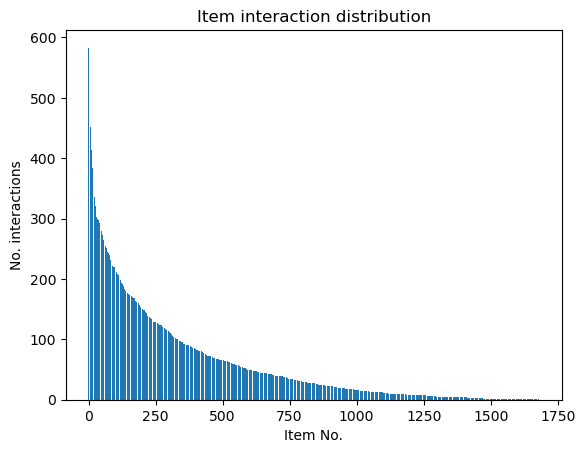

In [7]:
def plot_item_popularity_distribution(interaction_matrix, y_label="No. interactions", x_label="Item No.", title="Item interaction distribution", ax=None):
    intrxn_per_item = np.sort(np.sum(interaction_matrix, axis=0))[::-1]
    fig = plt.bar(np.arange(intrxn_per_item.size), intrxn_per_item)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    return fig

plot_item_popularity_distribution(binary_ratings_matrix)

In [6]:
metrics_list = [
    MSEMeasurement(diagnostics=True),
    MeanCosineSim(pairs=intra_cluster_user_pairs, name='mean_intra_cluster_cosine_sim', diagnostics=True),
    InteractionSimilarity(pairs=intra_cluster_user_pairs, name="test_interaction_similarity", diagnostics=True),
    InteractionSpread(),
    InteractionMeasurement(),
    TopicInteractionMeasurement(),
    TopicInteractionSpread()
]

metric_to_y_label = {
    "mse":"mse",
    "mean_intra_cluster_cosine_sim":"average intra-cluster cosine sim",
    "interaction_spread":"item interaction diversity",
    "topic_interaction_spread":"topic interaction diversity",
}

graphing_metrics = [
    "mse",
    "mean_intra_cluster_cosine_sim",
    "interaction_spread",
    "topic_interaction_spread"
]

bubble = BubbleBurster(
    actual_user_representation=users, 
    actual_item_representation=item_representation,
    item_topics=item_cluster_ids,
    num_attributes=num_attributes,
    num_items_per_iter=10,
    record_base_state=True
)

In [ ]:
train_timesteps = 2
run_timesteps = 5
repeated_training = 1

bubble.add_metrics(*metrics_list)
bubble.startup_and_train(timesteps=train_timesteps)
bubble.run(timesteps=run_timesteps, train_between_steps=repeated_training)
bubble.close() # end logging

In [28]:
# print(bubble.__dict__["metrics"])
print(bubble.__dict__.keys())
# print(dir(bubble))

dict_keys(['all_interactions', '_logger', 'metrics', 'users_hat', 'items_hat', 'score_fn', 'interleaving_fn', 'predicted_scores', 'probabilistic_recommendations', 'items_shown', 'interactions', 'users', 'items', 'creators', '_system_state', 'num_users', 'num_items', 'expand_items_per_iter', 'num_items_per_iter', 'random_state', 'indices', 'item_topics', 'num_topics', 'user_topic_history', 'item_count', 'topic_interactions'])


In [ ]:
measurements = bubble.get_measurements()
measurements.keys()

In [ ]:
def graph_metrics_by_axis(ax, results, metric_key, metric_key_map):
    ax.plot(results[metric_key])#, label=metric_key)
    ax.set_title(f"{metric_key}")
    ax.set_ylabel(metric_key_map[metric_key])
    ax.set_xlabel("Timestep")
    return ax

Inheriting from BaseRecommender


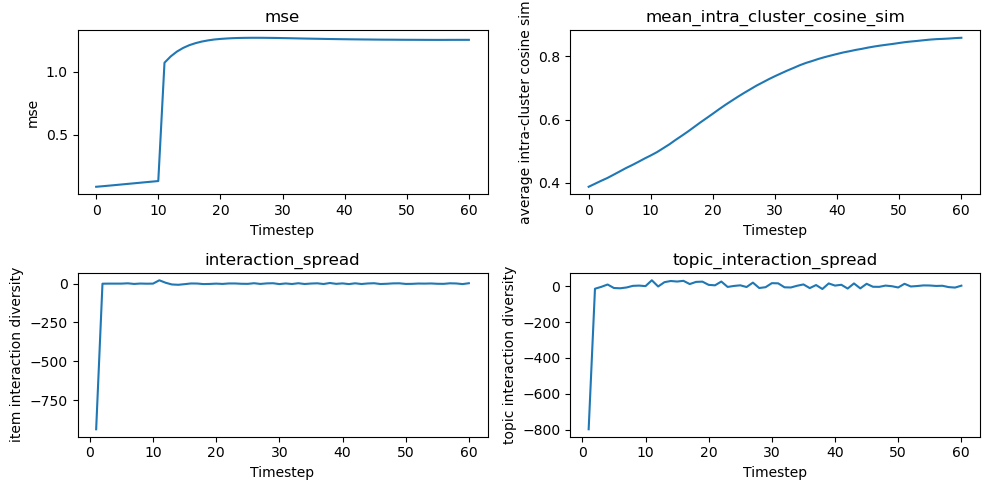

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
for i in range(4):
    curr_ax = axs[int(i >= 2), i%2]
    graph_metrics_by_axis(curr_ax, measurements, graphing_metrics[i], metric_to_y_label)
plt.tight_layout()
print("Inheriting from BaseRecommender")

In [ ]:
mse = metrics_list[0]
mse.get_diagnostics()

,mean,std,median,min,max,skew,kurtosis,sw_stat,sw_p,n
0,0.014230,0.008812,0.012875,0.000516,0.063828,1.158491,2.061006,0.927908,7.173578e-21,943.0
1,0.015730,0.008937,0.014486,0.001260,0.067727,1.113371,2.001397,0.934304,6.048900e-20,943.0
2,0.017294,0.009021,0.016170,0.002180,0.068325,1.027321,1.670650,0.942775,1.305633e-18,943.0
3,0.018879,0.009051,0.017727,0.003085,0.068770,0.931015,1.330807,0.951309,4.103365e-17,943.0
4,0.020552,0.009035,0.019597,0.004625,0.068754,0.846011,1.077879,0.958589,1.112231e-15,943.0
...,...,...,...,...,...,...,...,...,...,...
56,0.913004,0.221730,0.902516,0.310434,1.424838,-0.274425,-0.500405,0.966738,7.520724e-14,943.0
57,0.913696,0.222102,0.904719,0.309348,1.431945,-0.277982,-0.493088,0.966816,7.857330e-14,943.0
58,0.914228,0.222232,0.905073,0.310276,1.441790,-0.280580,-0.484149,0.966648,7.153811e-14,943.0
59,0.914517,0.222114,0.905065,0.308649,1.449168,-0.284110,-0.473367,0.966690,7.322884e-14,943.0


In [ ]:
def process_diagnostic(metric, diagnostics_var):
    # print(metric.get_diagnostics()[diagnostics_var].head(1))
    return metric.get_diagnostics()[diagnostics_var].to_numpy()#.to_dict(orient='list')

In [ ]:
diagnostic_metrics = set((
    "mse",
    "mean_intra_cluster_cosine_sim",
    "test_interaction_similarity"
))
# diagnostics_list = {k: defaultdict(list) for k in ["mean", "std", "median", "min", "max", "skew"]}
diagnostics_vars = ["mean", "std", "median", "min", "max", "skew"]

model_diagnostics = {k: defaultdict(list) for k in diagnostic_metrics}

model_diagnostics

{'mse': defaultdict(list, {}),
 'test_interaction_similarity': defaultdict(list, {}),
 'mean_intra_cluster_cosine_sim': defaultdict(list, {})}

In [ ]:
for metric in metrics_list:
    if metric.name in diagnostic_metrics:
        for diagnostic in diagnostics_vars:
            model_diagnostics[metric.name][diagnostic].append(process_diagnostic(metric, diagnostic))

print(model_diagnostics.keys())
model_diagnostics

dict_keys(['mse', 'test_interaction_similarity', 'mean_intra_cluster_cosine_sim'])


{'mse': defaultdict(list,
             {'mean': [array([0.01423034, 0.0157296 , 0.01729428, 0.01887887, 0.0205519 ,
                      0.02221198, 0.0239513 , 0.02562519, 0.02736049, 0.02907656,
                      0.03076435, 0.72368238, 0.77212662, 0.80907558, 0.83681109,
                      0.85787695, 0.87311764, 0.88486027, 0.89370178, 0.90062068,
                      0.9049818 , 0.90822068, 0.91076172, 0.91237577, 0.91332844,
                      0.91399649, 0.91417387, 0.91412765, 0.91397538, 0.91379119,
                      0.913205  , 0.91289306, 0.9122843 , 0.91167849, 0.91114437,
                      0.91071659, 0.91041704, 0.91005693, 0.90969823, 0.90954722,
                      0.90937184, 0.90926139, 0.90924332, 0.90910452, 0.90926019,
                      0.9093445 , 0.90941278, 0.90974733, 0.91005093, 0.91034043,
                      0.9105236 , 0.91083658, 0.911193  , 0.9115719 , 0.91194198,
                      0.91225851, 0.91300446, 0.9136963 , 0.9142

In [ ]:
model_name = "model1"

result_diagnostics = {k: defaultdict(list) for k in diagnostic_metrics}
for metric in result_diagnostics:
    result_diagnostics[metric][model_name] = model_diagnostics[metric]

In [ ]:
result_diagnostics

{'mse': defaultdict(list,
             {'model1': defaultdict(list,
                          {'mean': [array([0.01423034, 0.0157296 , 0.01729428, 0.01887887, 0.0205519 ,
                                   0.02221198, 0.0239513 , 0.02562519, 0.02736049, 0.02907656,
                                   0.03076435, 0.72368238, 0.77212662, 0.80907558, 0.83681109,
                                   0.85787695, 0.87311764, 0.88486027, 0.89370178, 0.90062068,
                                   0.9049818 , 0.90822068, 0.91076172, 0.91237577, 0.91332844,
                                   0.91399649, 0.91417387, 0.91412765, 0.91397538, 0.91379119,
                                   0.913205  , 0.91289306, 0.9122843 , 0.91167849, 0.91114437,
                                   0.91071659, 0.91041704, 0.91005693, 0.90969823, 0.90954722,
                                   0.90937184, 0.90926139, 0.90924332, 0.90910452, 0.90926019,
                                   0.9093445 , 0.90941278, 0.90974733